In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from analysis import collection, analysis

from pathlib import Path

import numpy as np
import scipy
from analysis import analysis
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from IPython.display import HTML

from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
def find_rise_point(sig):
    # where does the activity first go above a threshold?
    # assuming we've removed the hold steps
    # params
    num_to_avg = 10
    percentile = 0.15
    threshold = np.max(np.quantile(np.abs(sig),percentile,axis=0))

    # average the few steps of data
    offset = np.mean(sig[:num_to_avg,:],axis=0)

    # find the first point where values go above/below this average by a threshold amount
    # only use the "x" axis point
    return np.min(np.argmax(np.abs(sig - offset) > threshold, axis=0))

## mean zero covariance -- sample covariance assuming mean of every spatial dimension is 0

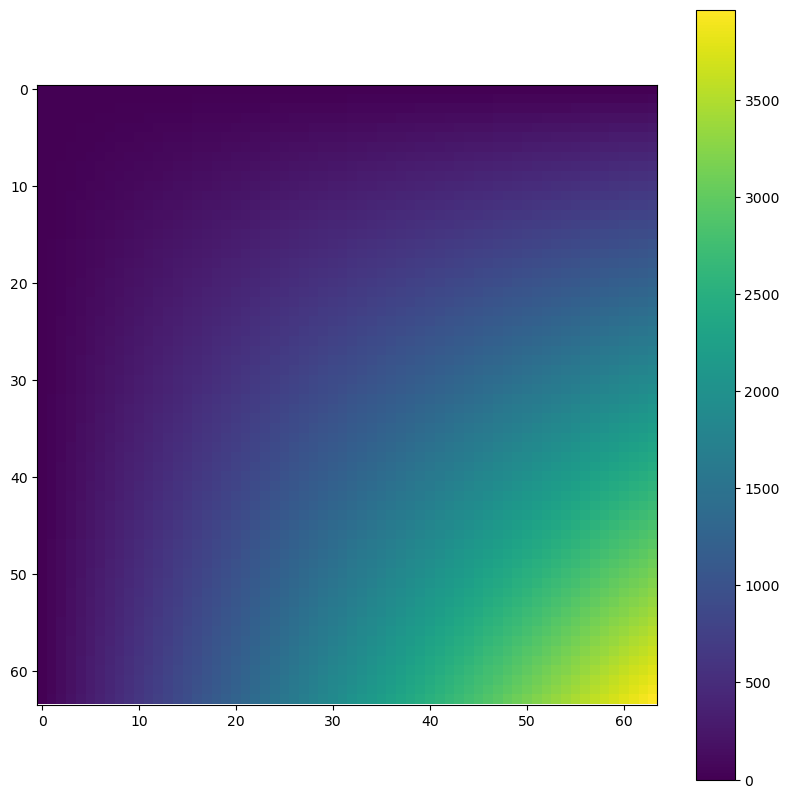

In [4]:
def mean_zero_cov(data):
    assert len(data.shape) == 2
    assert data.shape[1] == 64
    return (data.T @ data) / data.shape[0]

C = mean_zero_cov(np.vstack([range(64) for _ in range(100)]))
plt.figure(figsize=(10,10))
plt.imshow(C)
plt.colorbar()

In [5]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

## subject decoder norms

(1.0, 2.0)

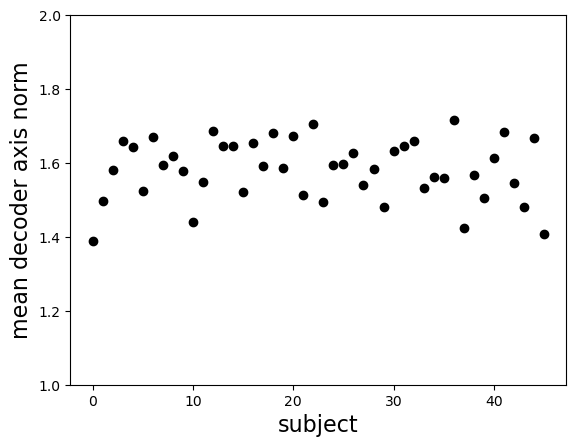

In [6]:
decoder_norms= []
for subject in subjects:
    decoder_norms.append(np.mean(np.linalg.norm(subject.decoder[-2:,:],axis=1),axis=0))
plt.plot(decoder_norms,"ko")
plt.xlabel("subject")
plt.ylabel("mean decoder axis norm")
plt.ylim([1,2])

## visualize activation filtering

#### find trials with most and least active points for a subject as an example

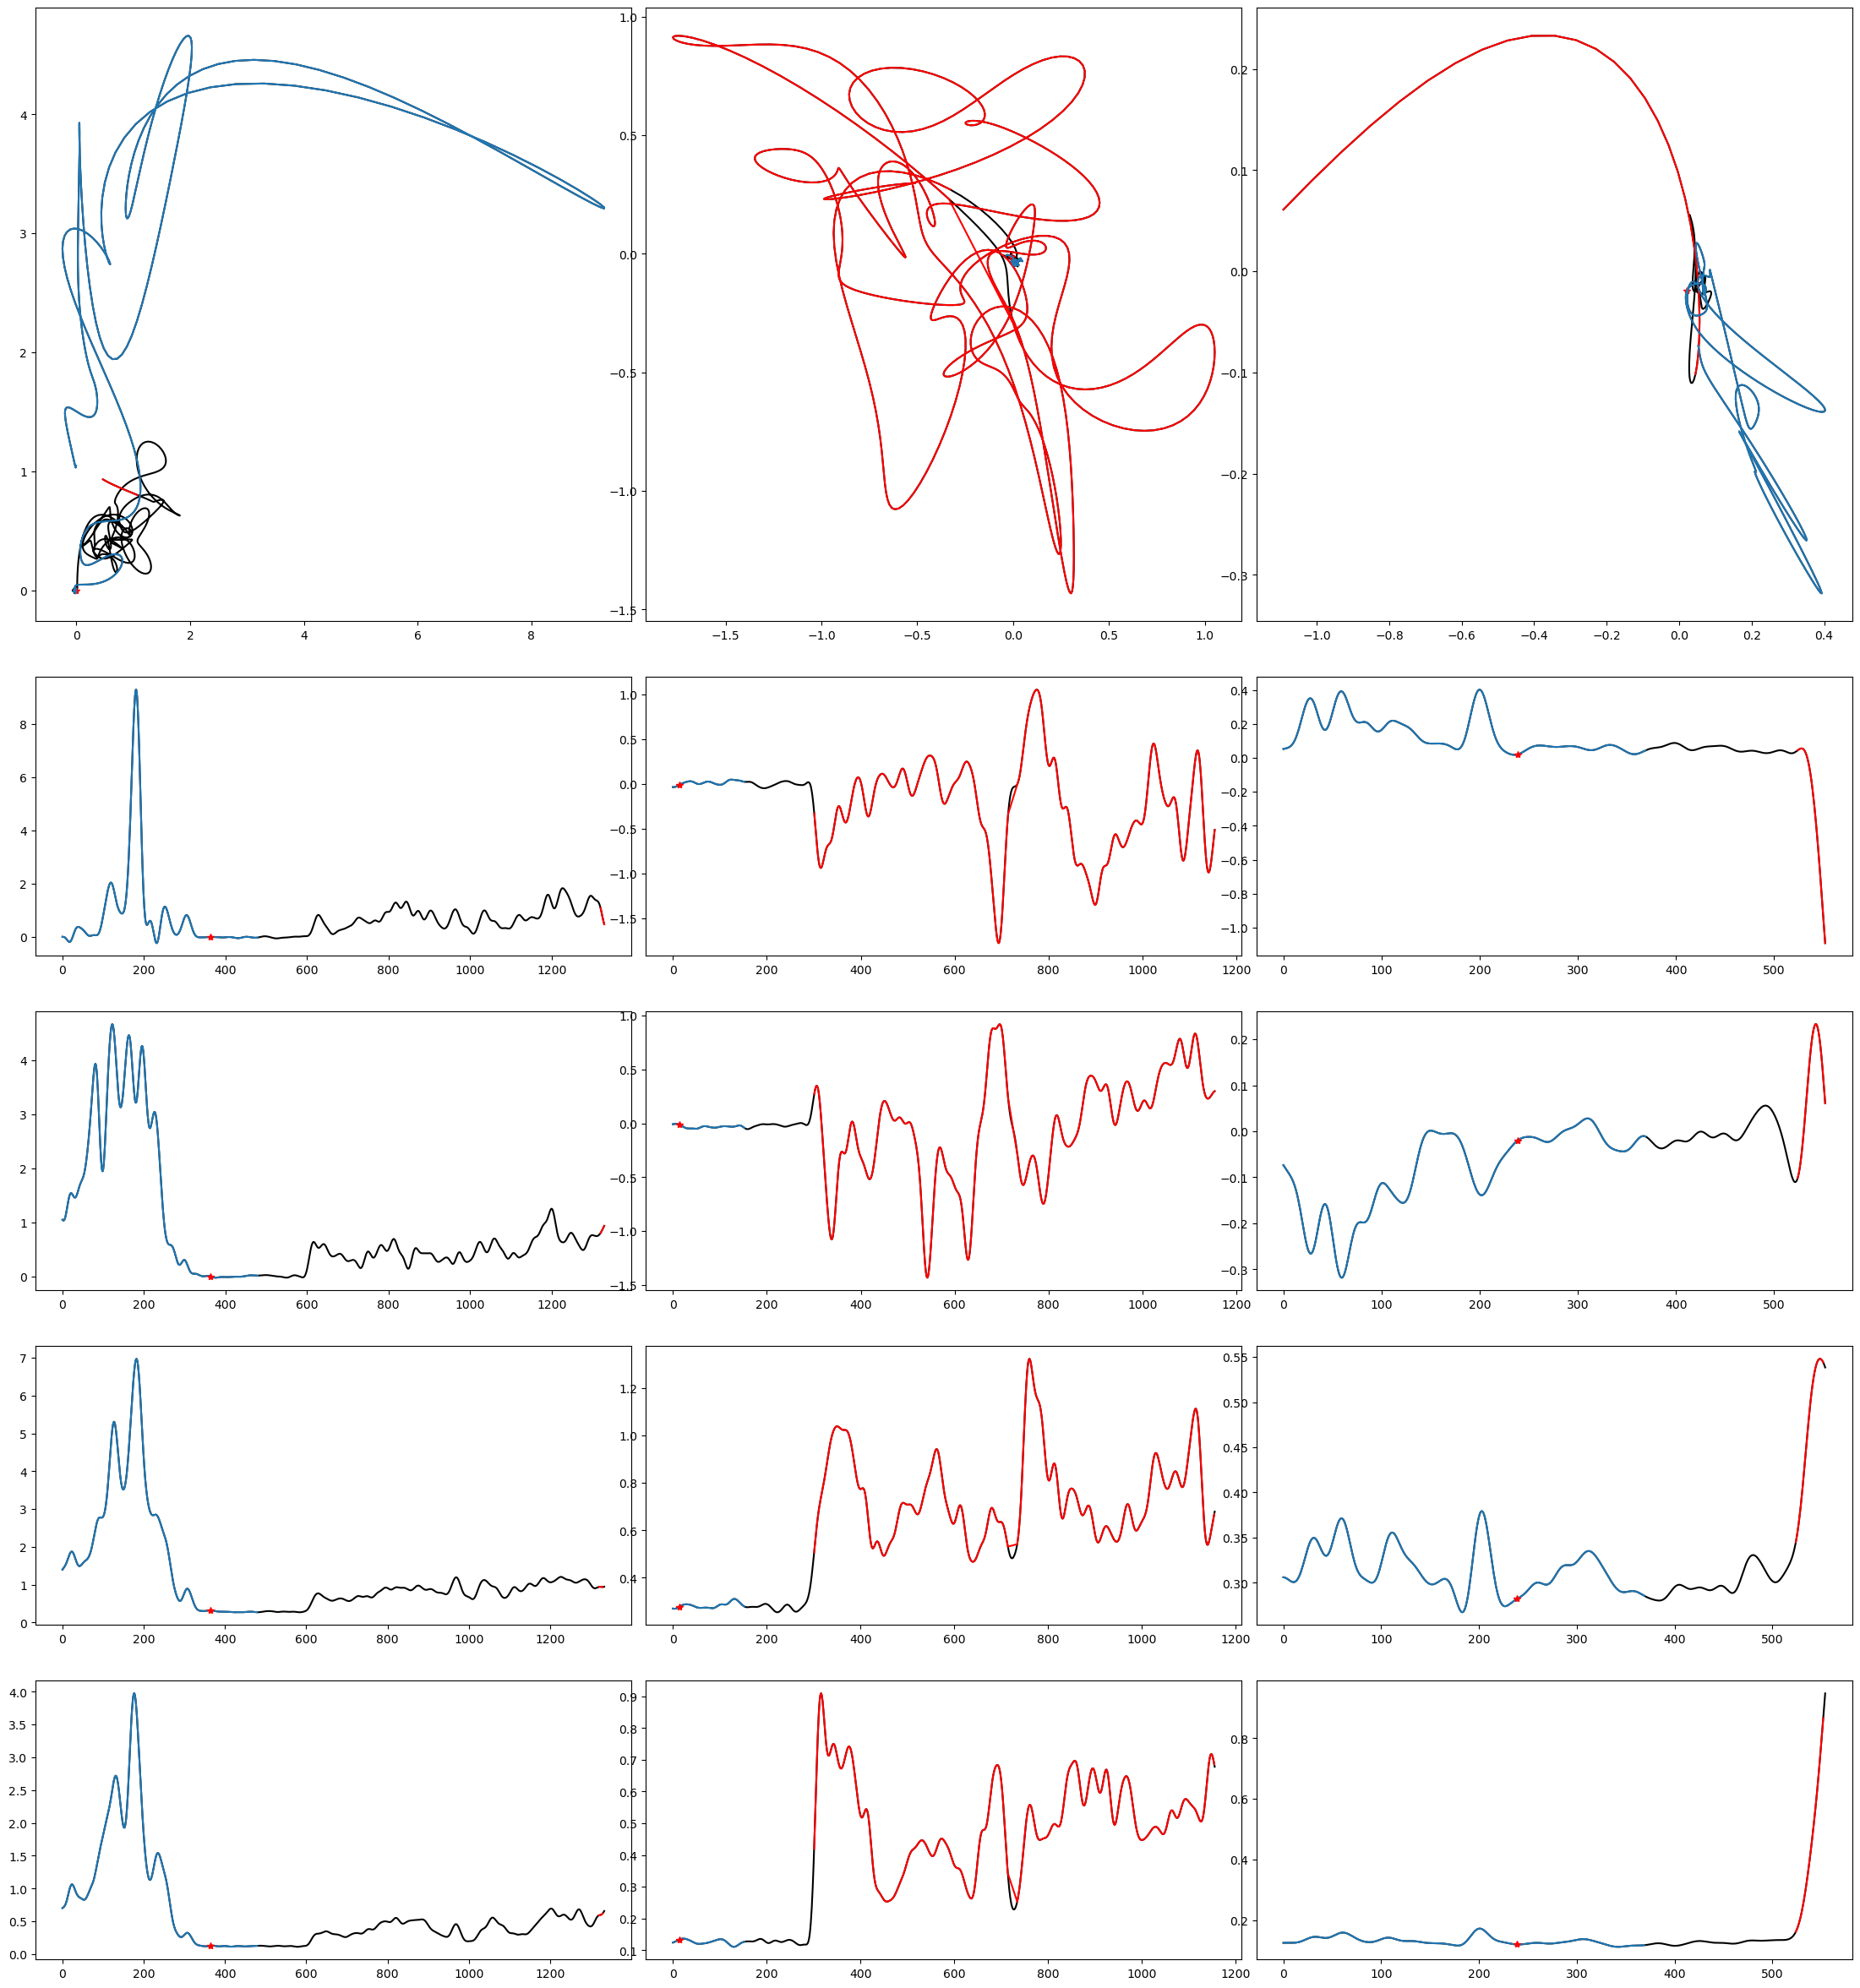

In [7]:
subject_idx = 13

medium_active_trial = (0,0,np.inf)
for session_idx, session in enumerate(subjects[subject_idx].tasks[task_name].sorted_sessions()):
    for trial_idx, trial in enumerate(session.sorted_trials()):
        if trial.outcome != "No Hold":
            num_active_samples = len(trial.active_indices)
            if np.abs(num_active_samples - 100) < medium_active_trial[2]:
                medium_active_trial = (session_idx, trial_idx, num_active_samples)

most_active_trial = (0,0,0)
for session_idx, session in enumerate(subjects[subject_idx].tasks[task_name].sorted_sessions()):
    for trial_idx, trial in enumerate(session.sorted_trials()):
        if trial.outcome != "No Hold":
            num_active_samples = len(trial.active_indices)
            if num_active_samples > most_active_trial[2]:
                most_active_trial = (session_idx, trial_idx, num_active_samples)

fewest_active_trial = (np.inf,np.inf,np.inf)
for session_idx, session in enumerate(subjects[subject_idx].tasks[task_name].sorted_sessions()):
    for trial_idx, trial in enumerate(session.sorted_trials()):
        if trial.outcome != "No Hold":
            num_active_samples = len(trial.active_indices)
            if num_active_samples < fewest_active_trial[2]:
                fewest_active_trial = (session_idx, trial_idx, num_active_samples)

fig = plt.figure(figsize=(50,30))

gs1 = GridSpec(6, 6, left=0.05, right=0.48, wspace=0.05)
ax1 = fig.add_subplot(gs1[0:2, :2])
ax2 = fig.add_subplot(gs1[2, :2])
ax3 = fig.add_subplot(gs1[3, :2])
ax4 = fig.add_subplot(gs1[4, :2])
ax5 = fig.add_subplot(gs1[5, :2])

gs2 = GridSpec(6, 6, left=0.05, right=0.48, wspace=0.05)
ax6 = fig.add_subplot(gs2[0:2, 2:4])
ax7 = fig.add_subplot(gs2[2, 2:4])
ax8 = fig.add_subplot(gs2[3, 2:4])
ax9 = fig.add_subplot(gs2[4, 2:4])
ax10 = fig.add_subplot(gs2[5, 2:4])

gs3 = GridSpec(6, 6, left=0.05, right=0.48, wspace=0.05)
ax11 = fig.add_subplot(gs2[0:2, 4:])
ax12 = fig.add_subplot(gs2[2, 4:])
ax13 = fig.add_subplot(gs2[3, 4:])
ax14 = fig.add_subplot(gs2[4, 4:])
ax15 = fig.add_subplot(gs2[5, 4:])


# getting lengths of trajectory and emg to match
# min_length = np.min([traj.shape[0],emg.shape[0]])
# traj = traj[:min_length,:]
# emg = emg[:min_length,:]


session_idx = fewest_active_trial[0]
trial_idx = fewest_active_trial[1]
trial = subjects[subject_idx].tasks[task_name].sorted_sessions()[session_idx].sorted_trials()[trial_idx]
active_emg_samples = trial.filtered_emg[trial.active_indices,:]
active_traj_samples = trial.trajectory[trial.active_indices,:]
hold_indices = range(int(200*trial.hold_time))

ax1.plot(trial.trajectory[:,0], trial.trajectory[:,1],"k")
ax1.plot(active_traj_samples[:,0], active_traj_samples[:,1], "r")
ax1.plot(trial.trajectory[trial.trajectory_low_point,0], trial.trajectory[trial.trajectory_low_point,1], "r*")
ax1.plot(trial.trajectory[hold_indices,0],trial.trajectory[hold_indices,1])

ax2.plot(trial.trajectory[:,0],"k")
ax2.plot(trial.active_indices, active_traj_samples[:,0], "r")
ax2.plot(trial.trajectory[hold_indices,0], "tab:blue")
ax2.plot(trial.trajectory_low_point, trial.trajectory[trial.trajectory_low_point,0], "r*")

ax3.plot(trial.trajectory[:,1],"k")
ax3.plot(trial.active_indices, active_traj_samples[:,1], "r")
ax3.plot(trial.trajectory[hold_indices,1], "tab:blue")
ax3.plot(trial.trajectory_low_point, trial.trajectory[trial.trajectory_low_point,1], "r*")

ax4.plot(trial.filtered_emg[:,4],"k")
ax4.plot(trial.filtered_emg[hold_indices,4],"tab:blue")
ax4.plot(trial.active_indices, active_emg_samples[:,4], "r")
ax4.plot(trial.trajectory_low_point, trial.filtered_emg[trial.trajectory_low_point,4], "r*")

ax5.plot(trial.filtered_emg[:,54],"k")
ax5.plot(trial.filtered_emg[hold_indices,54],"tab:blue")
ax5.plot(trial.active_indices, active_emg_samples[:,54], "r")
ax5.plot(trial.trajectory_low_point, trial.filtered_emg[trial.trajectory_low_point,54], "r*")



session_idx = most_active_trial[0]
trial_idx = most_active_trial[1]
trial = subjects[subject_idx].tasks[task_name].sorted_sessions()[session_idx].sorted_trials()[trial_idx]
active_emg_samples = trial.filtered_emg[trial.active_indices,:]
active_traj_samples = trial.trajectory[trial.active_indices,:]
hold_indices = range(int(200*trial.hold_time))

ax6.plot(trial.trajectory[:,0], trial.trajectory[:,1],"k")
ax6.plot(active_traj_samples[:,0], active_traj_samples[:,1], "r")
ax6.plot(trial.trajectory[trial.trajectory_low_point,0], trial.trajectory[trial.trajectory_low_point,1], "r*")
ax6.plot(trial.trajectory[hold_indices,0],trial.trajectory[hold_indices,1])

ax7.plot(trial.trajectory[:,0],"k")
ax7.plot(trial.active_indices, active_traj_samples[:,0], "r")
ax7.plot(trial.trajectory[hold_indices,0], "tab:blue")
ax7.plot(trial.trajectory_low_point, trial.trajectory[trial.trajectory_low_point,0], "r*")

ax8.plot(trial.trajectory[:,1],"k")
ax8.plot(trial.active_indices, active_traj_samples[:,1], "r")
ax8.plot(trial.trajectory[hold_indices,1], "tab:blue")
ax8.plot(trial.trajectory_low_point, trial.trajectory[trial.trajectory_low_point,1], "r*")

ax9.plot(trial.filtered_emg[:,4],"k")
ax9.plot(trial.filtered_emg[hold_indices,4],"tab:blue")
ax9.plot(trial.active_indices, active_emg_samples[:,4], "r")
ax9.plot(trial.trajectory_low_point, trial.filtered_emg[trial.trajectory_low_point,4], "r*")

ax10.plot(trial.filtered_emg[:,54],"k")
ax10.plot(trial.filtered_emg[hold_indices,54],"tab:blue")
ax10.plot(trial.active_indices, active_emg_samples[:,54], "r")
ax10.plot(trial.trajectory_low_point, trial.filtered_emg[trial.trajectory_low_point,54], "r*")



session_idx = medium_active_trial[0]
trial_idx = medium_active_trial[1]
trial = subjects[subject_idx].tasks[task_name].sorted_sessions()[session_idx].sorted_trials()[trial_idx]
active_emg_samples = trial.filtered_emg[trial.active_indices,:]
active_traj_samples = trial.trajectory[trial.active_indices,:]
hold_indices = range(int(200*trial.hold_time))

ax11.plot(trial.trajectory[:,0], trial.trajectory[:,1],"k")
ax11.plot(active_traj_samples[:,0], active_traj_samples[:,1], "r")
ax11.plot(trial.trajectory[trial.trajectory_low_point,0], trial.trajectory[trial.trajectory_low_point,1], "r*")
ax11.plot(trial.trajectory[hold_indices,0],trial.trajectory[hold_indices,1])

ax12.plot(trial.trajectory[:,0],"k")
ax12.plot(trial.active_indices, active_traj_samples[:,0], "r")
ax12.plot(trial.trajectory[hold_indices,0], "tab:blue")
ax12.plot(trial.trajectory_low_point, trial.trajectory[trial.trajectory_low_point,0], "r*")

ax13.plot(trial.trajectory[:,1],"k")
ax13.plot(trial.active_indices, active_traj_samples[:,1], "r")
ax13.plot(trial.trajectory[hold_indices,1], "tab:blue")
ax13.plot(trial.trajectory_low_point, trial.trajectory[trial.trajectory_low_point,1], "r*")

ax14.plot(trial.filtered_emg[:,4],"k")
ax14.plot(trial.filtered_emg[hold_indices,4],"tab:blue")
ax14.plot(trial.active_indices, active_emg_samples[:,4], "r")
ax14.plot(trial.trajectory_low_point, trial.filtered_emg[trial.trajectory_low_point,4], "r*")

ax15.plot(trial.filtered_emg[:,54],"k")
ax15.plot(trial.filtered_emg[hold_indices,54],"tab:blue")
ax15.plot(trial.active_indices, active_emg_samples[:,54], "r")
ax15.plot(trial.trajectory_low_point, trial.filtered_emg[trial.trajectory_low_point,54], "r*")




## find the subject "max" activity to normalize across subjects

In [8]:
subject_maxes = {}
for subject_idx, subject in enumerate(c.alphabetically_sorted_subjects()):
    emg_block = np.empty(shape=(0,64))
    for session in subject.tasks[task_name].sorted_sessions():
        for trial in session.sorted_trials():
            if trial.outcome != "No Hold":
                emg = trial.get_filtered_emg().copy()
                active_emg = emg[trial.active_indices,:]
                emg_block = np.row_stack([emg_block, active_emg])
    p = np.percentile(emg_block,90)
    subject_maxes[subject.name] = p            

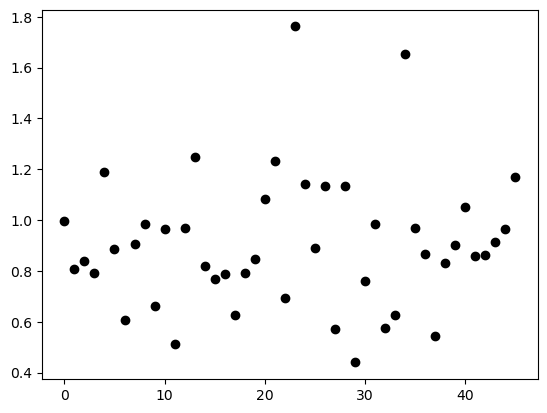

In [9]:
plt.plot(list(subject_maxes.values()),"ko")

## number of hits over subjects

In [8]:
hit_fractions = {}
hit_fraction_list = []
for subject in c.alphabetically_sorted_subjects():
    trial_list = []
    for session in subject.tasks[task_name].sorted_sessions():
        trial_list.extend(list(session.sorted_trials())) 
    num_trials = len(trial_list)
    hf = (sum([outcome["hits"] for outcome in [session.outcome_counts for session in subject.tasks[task_name].sorted_sessions()]]) / num_trials)
    hit_fractions[subject.name] = hf
    hit_fraction_list.append(hf)

## subspace projections of hit "ends" over subjects, over targets

In [9]:
# each trial has a hit end, compute this ahead of time

# number of endpoints of the trajectory we're using as the "final" activation
NUM_ENDPOINTS = 3
MIN_HITS = 3

# get emg ending activity means over hit trials for each target
hit_ends = {}
for subject in c.alphabetically_sorted_subjects():
    hit_ends[subject.name] = []
    # targets
    for target_idx in range(1,13):
        target_hit_ends = []
        # trials
        for session in list(subject.tasks[task_name].sorted_sessions()):
            for trial in session.sorted_trials():
                # only hits on that target
                if trial.target_number == target_idx:
                    if trial.outcome == "Hit":
                        end_mean = np.mean(trial.get_filtered_emg()[-NUM_ENDPOINTS:,:], axis=0) # / subject_maxes[subject.name]
                        target_hit_ends.append(end_mean)
        # all the end activity for this target's hits
        # this might be empty if there are no hits on that target in the whole session
        # in this case, we should put None and deal with it later
        if len(target_hit_ends) > MIN_HITS:
            hit_ends[subject.name].append(np.array(target_hit_ends))
        else:
            hit_ends[subject.name].append(None)

# mean ratio for each target hit end's covariance
hit_end_ratios = {}
hit_end_task_vars = {}
hit_end_null_vars = {}
for subject_name, target_list in hit_ends.items():
    hit_end_task_vars[subject_name] = []
    hit_end_null_vars[subject_name] = []
    hit_end_ratios[subject_name] = []
    for emg_ends in target_list:
        if not emg_ends is None:
            # compute covariance across trials
            # cov = np.cov(emg_ends.T)
            cov = mean_zero_cov(emg_ends)
            task = collection.mean_quadratic_form(cov, c.subjects[subject_name].task_subspace)
            null = collection.mean_quadratic_form(cov, c.subjects[subject_name].null_subspace)
            hit_end_task_vars[subject_name].append(task[0])
            hit_end_null_vars[subject_name].append(null[0])
            hit_end_ratios[subject_name].append((task/null)[0])
        else:
            hit_end_task_vars[subject_name].append(np.nan)
            hit_end_null_vars[subject_name].append(np.nan)
            hit_end_ratios[subject_name].append(np.nan)

# means over all targets
mean_hit_end_task_vars = {}
for subject_name, target_task_vars in hit_end_task_vars.items():
    mean_hit_end_task_vars[subject_name] = np.nanmean([t for t in target_task_vars if not t is None])

mean_hit_end_null_vars = {}
for subject_name, target_null_vars in hit_end_null_vars.items():
    mean_hit_end_null_vars[subject_name] = np.nanmean([t for t in target_null_vars if not t is None])

mean_hit_end_ratios = {}
for subject_name, target_ratios in hit_end_ratios.items():
    mean_hit_end_ratios[subject_name] = np.nanmean([t for t in target_ratios if not t is None])


## "active" emg subspace projections over subjects

In [10]:
# subjects, trials, targets
emg_task_vars = np.zeros(shape=(46,45,12))
emg_task_vars[:,:,:] = np.nan
emg_null_vars = np.zeros(shape=(46,45,12))
emg_null_vars[:,:,:] = np.nan
emg_ratios = np.zeros(shape=(46,45,12))
emg_ratios[:,:,:] = np.nan
subject_colors = np.zeros(shape=(46,45,12),dtype=str)
subject_colors[:,:,:] = np.nan

for subject_idx, subject in enumerate(c.alphabetically_sorted_subjects()):
    for target_idx in range(1,13):
        # go through each trial and compute the within-trial covariance, project it
        session_idx = -1
        for session in subject.tasks[task_name].sorted_sessions():
            session_idx += 1
            for trial in session.sorted_trials():
                if trial.outcome == "No Hold":
                    continue
                if trial.target_number == target_idx:
                    emg = trial.get_filtered_emg().copy()
                    active_emg = emg[trial.active_indices,:] # / subject_maxes[subject.name]
                    # compute covariance within the trial
                    # active_emg_cov = np.cov(active_emg.T)
                    active_emg_cov = mean_zero_cov(active_emg)
                    # project onto subspaces, averaged over dimensions
                    task_var = collection.mean_quadratic_form(active_emg_cov, subject.task_subspace)
                    null_var = collection.mean_quadratic_form(active_emg_cov, subject.null_subspace)
            
                    emg_task_vars[subject_idx,session_idx,target_idx-1] = task_var[0]
                    emg_null_vars[subject_idx,session_idx,target_idx-1] = null_var[0]
                    emg_ratios[subject_idx,session_idx,target_idx-1] = (task_var / null_var)[0]
                    
                    if trial.outcome == "Hit":
                        color = "tab:red"
                    elif trial.outcome == "Miss":
                        color = "tab:blue"                        
                    subject_colors[subject_idx,session_idx,target_idx-1] = color

## "active" emg var ratio per block, mixed targets

In [11]:
# subjects, trials, targets
emg_block_ratios = np.zeros(shape=(46,45,12))
emg_block_ratios[:,:,:] = np.nan

for subject_idx, subject in enumerate(c.alphabetically_sorted_subjects()):
    # go through each trial and compute the within-trial covariance, project it
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()):
        for trial in session.sorted_trials():
            if trial.outcome == "No Hold":
                continue
            emg = trial.get_filtered_emg().copy()
            active_emg = emg[trial.active_indices,:] # / subject_maxes[subject.name]
            # compute variance projections
            # active_emg_cov = np.cov(active_emg.T)
            active_emg_cov = mean_zero_cov(active_emg)
            task_var = collection.mean_quadratic_form(active_emg_cov, subject.task_subspace)
            null_var = collection.mean_quadratic_form(active_emg_cov, subject.null_subspace)
            emg_block_ratios[subject_idx,session_idx,trial.recorded_number] = (task_var / null_var)[0]

# PLOTS

## example hit ends EMG for one subject, one target

[(43, 64), (36, 64), (39, 64), (45, 64), (44, 64), (40, 64), (39, 64), (41, 64), (41, 64), (44, 64), (44, 64), (42, 64)]


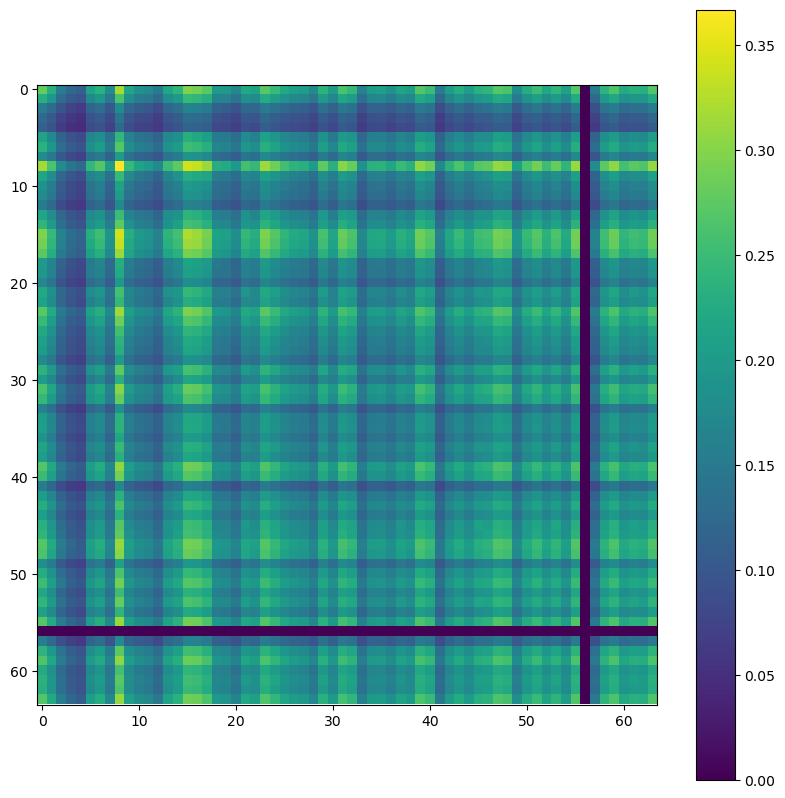

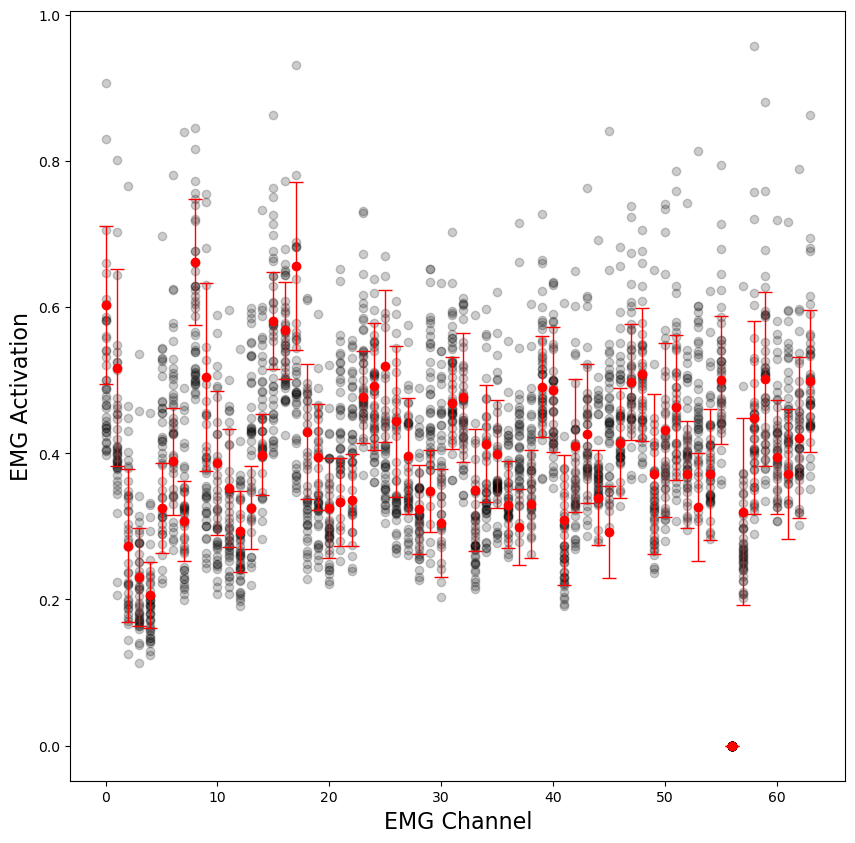

In [12]:
subject_idx = 35
target_idx = 11
for subject_name, he in list(hit_ends.items())[subject_idx:subject_idx+1]:
    print([x.shape for x in he])
    plt.figure(figsize=(10,10))
    plt.imshow(mean_zero_cov(he[target_idx]))
    plt.colorbar()
    plt.figure(figsize=(10,10))
    for hex in he[target_idx]:
        plt.plot(hex,'ko',alpha=0.2)
    plt.errorbar(range(64),np.nanmean(he[0],axis=0),yerr=np.nanstd(he[0],axis=0), marker="o", capsize=5, elinewidth=1, linewidth=0, color="r")
    plt.xlabel("EMG Channel")
    plt.ylabel("EMG Activation")
    break

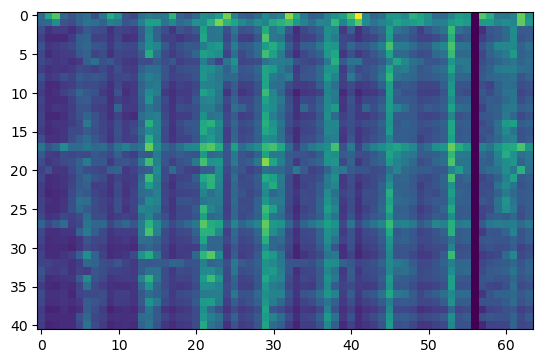

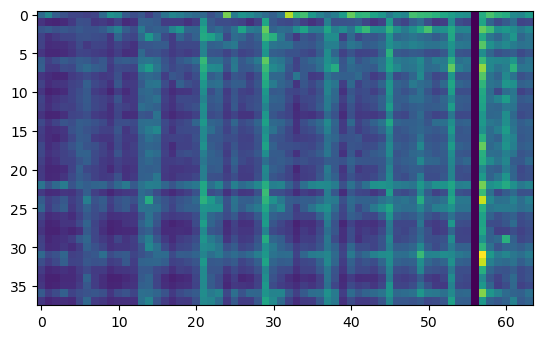

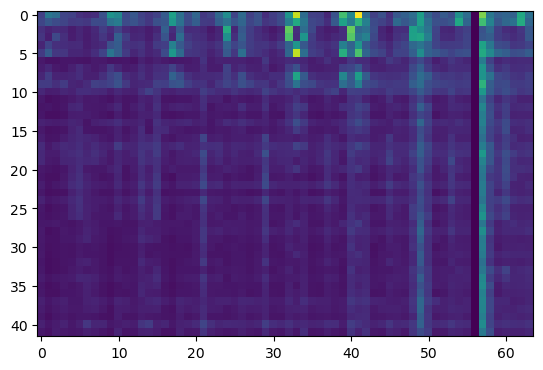

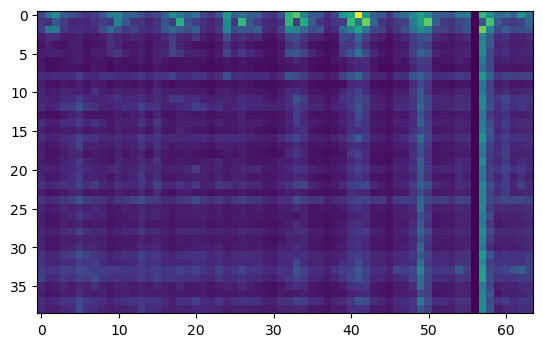

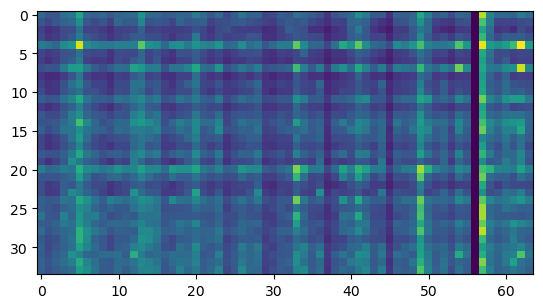

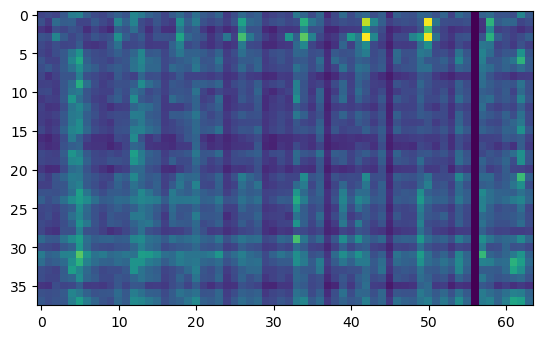

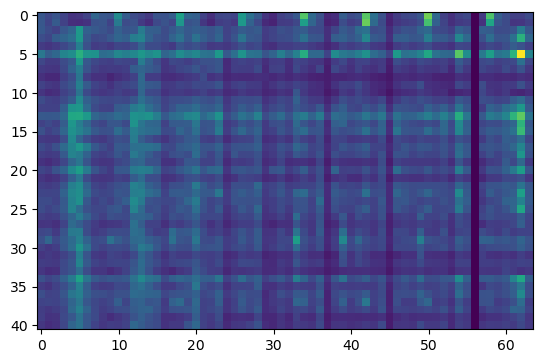

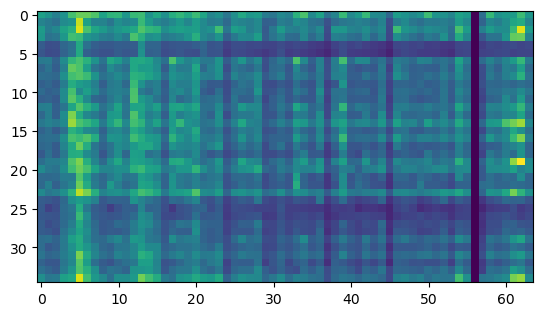

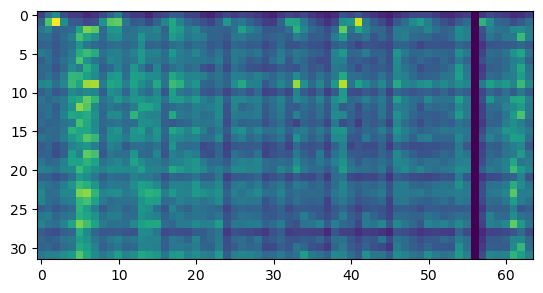

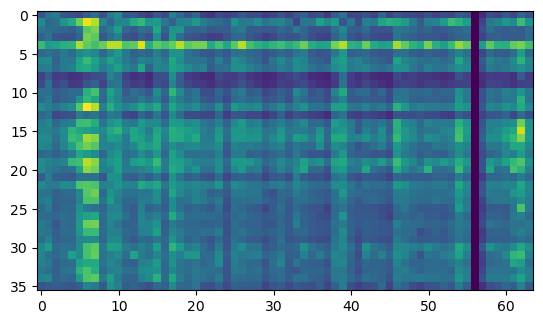

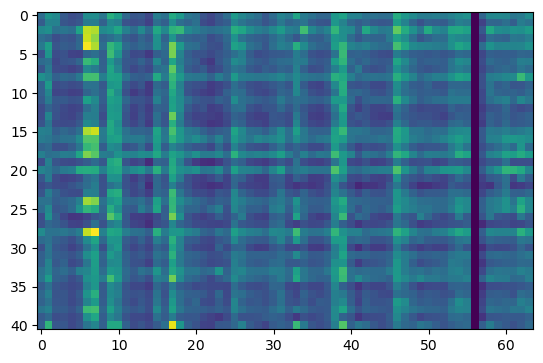

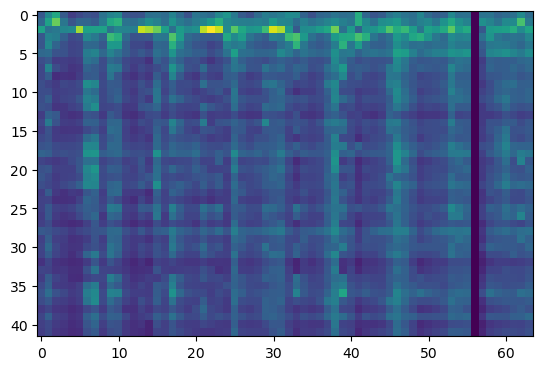

In [20]:
subject = subjects[22]
for he in hit_ends[subject.name]:
    plt.figure()
    plt.imshow(he)

## hit end variance ratio + mean "active" emg variance ratio VS targets FOR ALL subjects

(46, 45, 12)


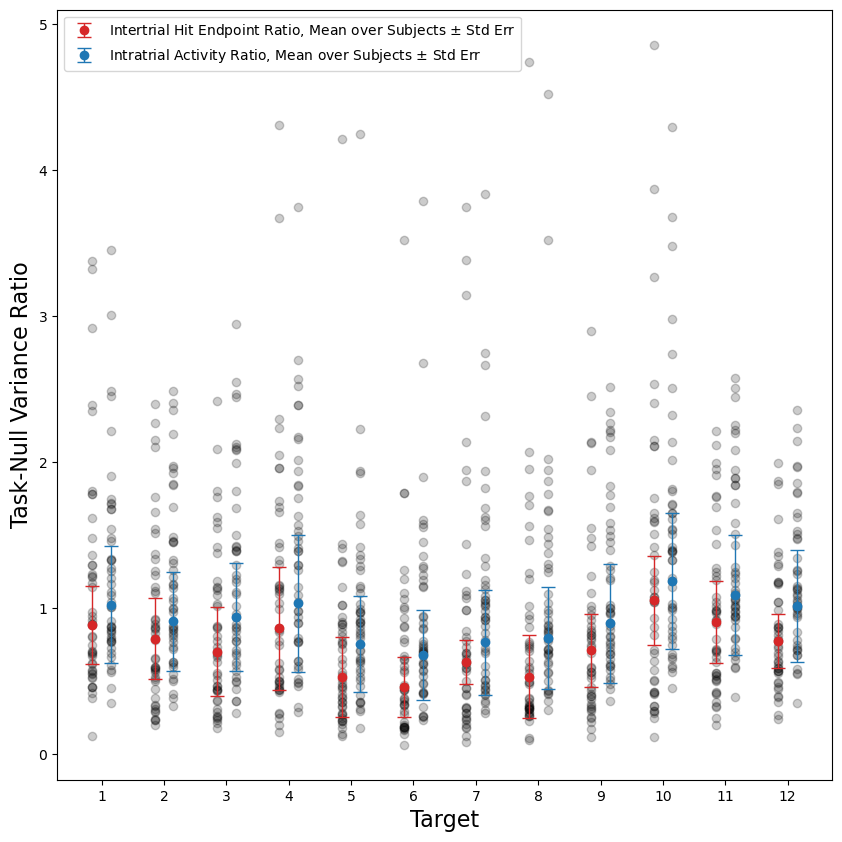

In [23]:
plt.figure(figsize=(10,10))
hit_end_ratio_stack = np.zeros(shape=(12,))
# plotting subjects for each target
for subject in c.alphabetically_sorted_subjects():
    hit_end_ratio_stack = np.vstack([hit_end_ratio_stack, hit_end_ratios[subject.name]])
    plt.plot(hit_end_ratios[subject.name],"ko",alpha=0.2)
hit_end_ratio_stack = hit_end_ratio_stack[1:,:]
# mean over subjects for each target
plt.errorbar(range(12),np.nanmedian(hit_end_ratio_stack,axis=0),yerr=scipy.stats.iqr(hit_end_ratio_stack,axis=0,nan_policy="omit",rng=(40,60)), marker="o", capsize=5, elinewidth=1, linewidth=0, color="tab:red",label="Intertrial Hit Endpoint Ratio, Mean over Subjects $\pm$ Std Err")

# subject, target, trial
print(emg_ratios.shape)

# means over trials for each target -- plotting targets v. subjects
x = [x+0.3 for x in range(12)]
for subject_trial_mean, subject_trial_std in zip(np.nanmean(emg_ratios, axis=1), np.nanstd(emg_ratios, axis=1)):
    plt.plot(x, subject_trial_mean, "o", color="k", alpha=0.2)
# mean over subjects and trials for each target
plt.errorbar(x,np.nanmedian(emg_ratios,axis=(0,1)),yerr=scipy.stats.iqr(emg_ratios,axis=(0,1),nan_policy="omit",rng=(40,60)), marker="o", capsize=5, elinewidth=1, linewidth=0, color="tab:blue",label="Intratrial Activity Ratio, Mean over Subjects $\pm$ Std Err")

plt.xticks([x+0.15 for x in range(12)], labels=[x+1 for x in range(12)])
plt.xlabel("Target")
plt.ylabel("Task-Null Variance Ratio")
plt.legend()

The inter-subject variability here is pretty broad. Can we plot the individual subject ratios against something else and see if they cluster?

## effect of window size of the hit end on the mean over subjects per target

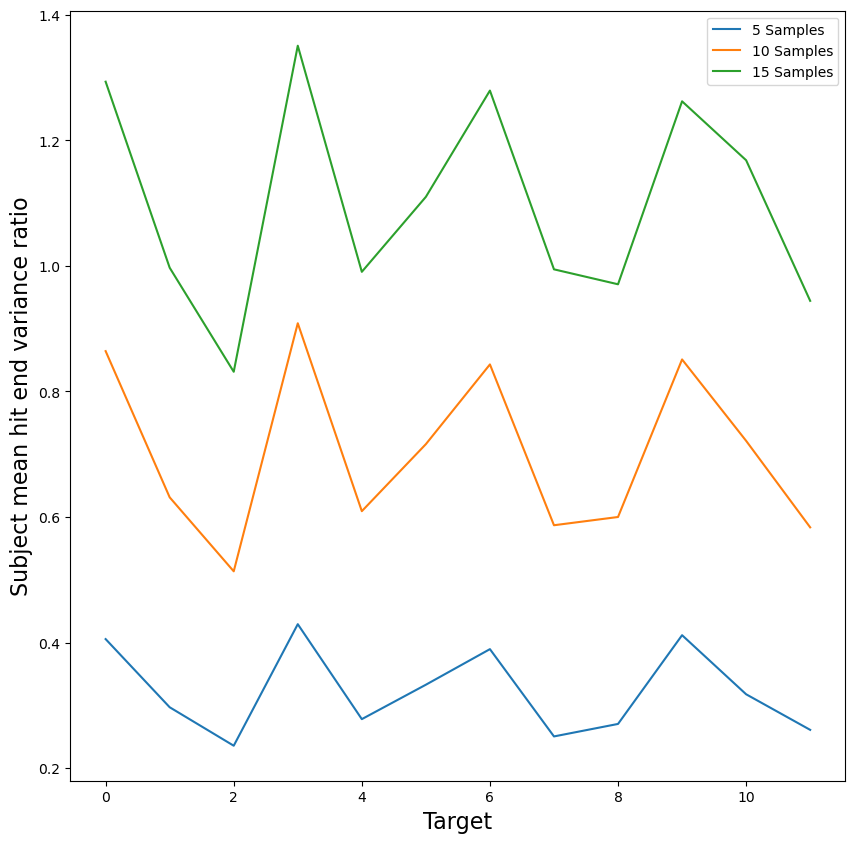

In [26]:
samples_5 = [0.40543724, 0.29683056, 0.23553798, 0.42920112, 0.27790572, 0.33274453, 0.38942939, 0.25033928, 0.27024989, 0.41164893, 0.31751965, 0.26080828]
samples_10 = [0.86427778, 0.63130813, 0.51341782, 0.90867263, 0.60925327, 0.71606523, 0.84308134, 0.58683775, 0.59997757, 0.85101878, 0.72133085, 0.58348162]
samples_15 = [1.29356638, 0.99714795, 0.83137877, 1.35087351, 0.9906097, 1.11008976, 1.2794176 , 0.99457665, 0.97077403, 1.26228672, 1.16839835, 0.94437787]

plt.figure(figsize=(10,10))
plt.plot(samples_5, label="5 Samples")
plt.plot(samples_10, label="10 Samples")
plt.plot(samples_15, label="15 Samples")
plt.ylabel("Subject mean hit end variance ratio")
plt.xlabel("Target")
plt.legend()

## hit fractions VS mean hit end ratio FOR ALL subjects (mean over targets)

Text(0, 0.5, 'Null Variance, Mean over Targets')

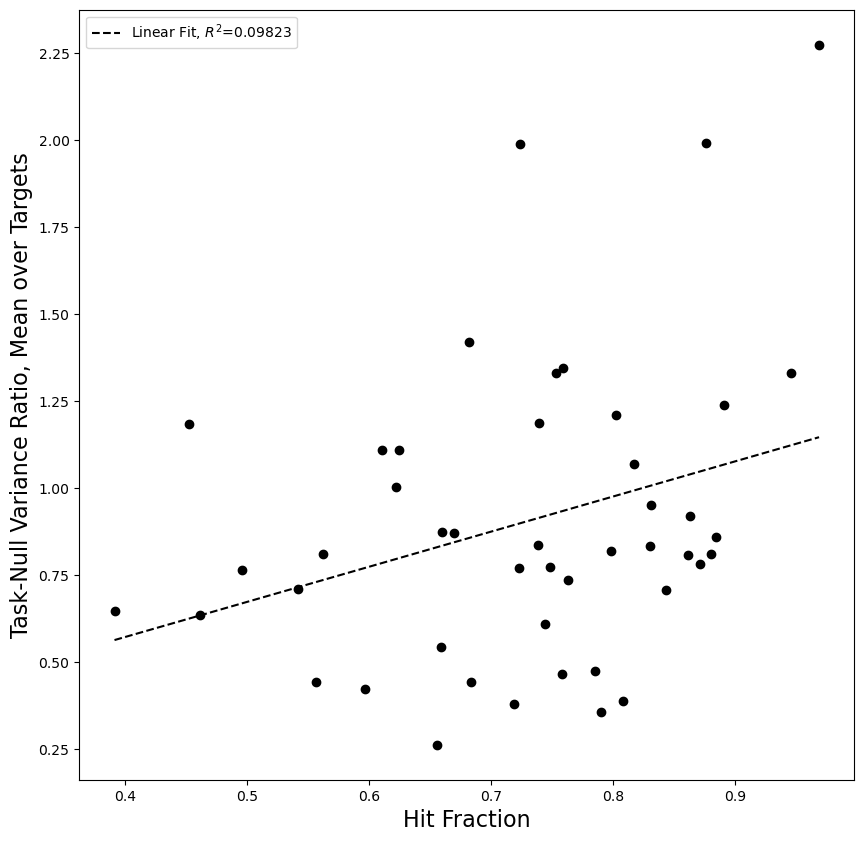

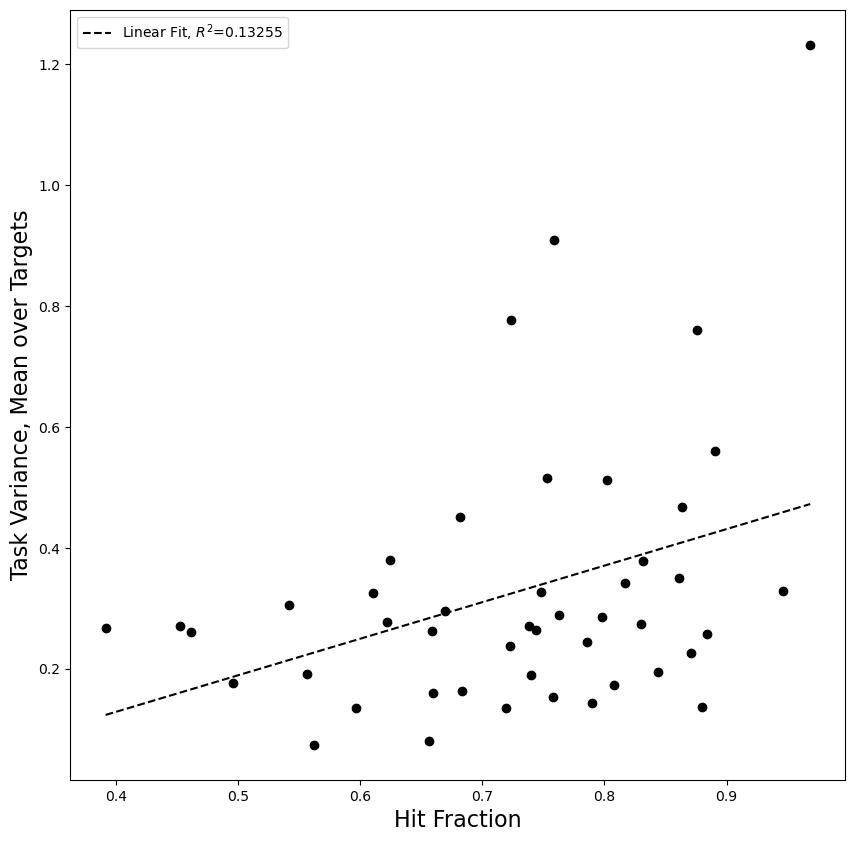

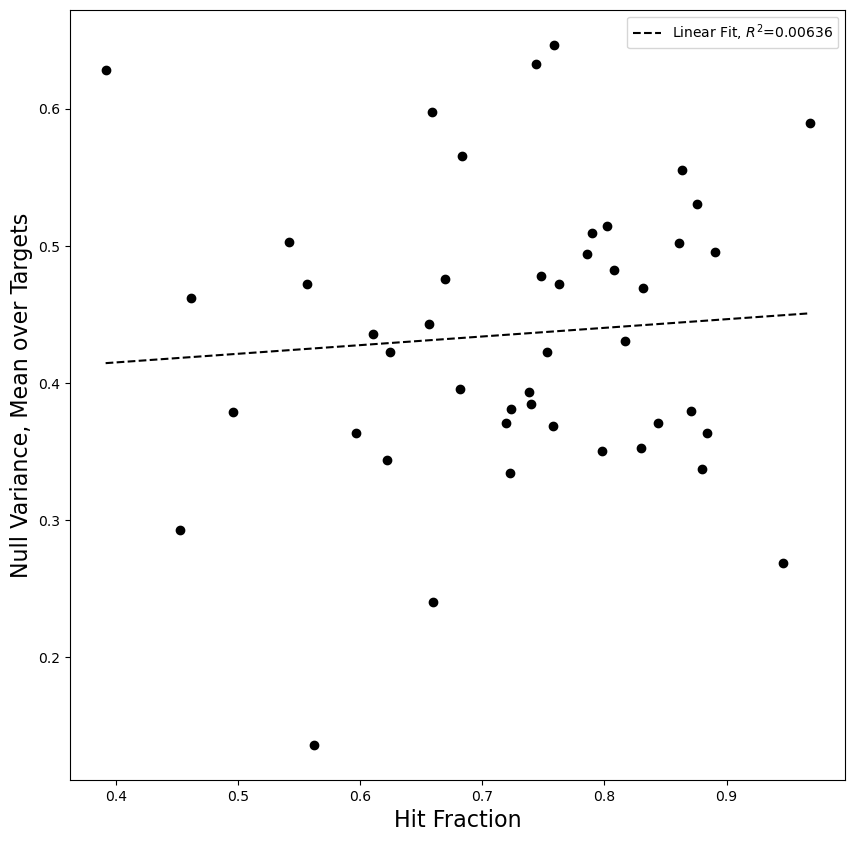

In [17]:
hfs, mean_ratios, task_vars, null_vars = [], [], [], []
for subject_name, mean_ratio in mean_hit_end_ratios.items():
    mean_ratios.append(mean_ratio)
    hfs.append(hit_fractions[subject_name])
    task_vars.append(mean_hit_end_task_vars[subject_name])
    null_vars.append(mean_hit_end_null_vars[subject_name])

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(hfs, mean_ratios, "ko")
x = np.linspace(np.min(hfs), np.max(hfs), len(hfs))
result = scipy.stats.linregress(hfs, mean_ratios)
ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
ax.legend()
ax.set_xlabel("Hit Fraction")
ax.set_ylabel("Task-Null Variance Ratio, Mean over Targets")

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(hfs, task_vars, "ko")
x = np.linspace(np.min(hfs), np.max(hfs), len(hfs))
result = scipy.stats.linregress(hfs, task_vars)
ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
ax.legend()
ax.set_xlabel("Hit Fraction")
ax.set_ylabel("Task Variance, Mean over Targets")

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(hfs, null_vars, "ko")
x = np.linspace(np.min(hfs), np.max(hfs), len(hfs))
result = scipy.stats.linregress(hfs, null_vars)
ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
ax.legend()
ax.set_xlabel("Hit Fraction")
ax.set_ylabel("Null Variance, Mean over Targets")


## hits VS mean "active" emg variance ratio FOR ALL subjects (mean over targets and trials)

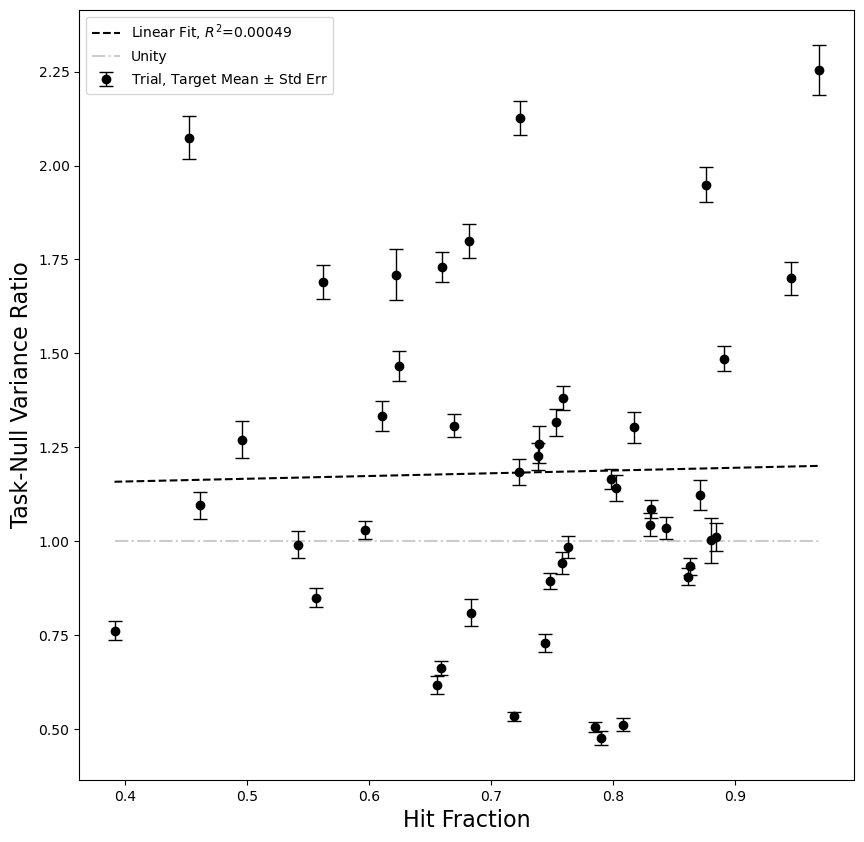

In [18]:
plt.figure(figsize=(10,10))

x = [x+0.5 for x in range(12)]

# means over trials and targets
plt.errorbar(hit_fraction_list, np.nanmean(emg_ratios,axis=(1,2)), yerr=np.nanstd(emg_ratios,axis=(1,2))/np.sqrt(12*45), marker="o", capsize=5, elinewidth=1, linewidth=0, color="k",label="Trial, Target Mean $\pm$ Std Err")
x = np.linspace(np.min(hit_fraction_list), np.max(hit_fraction_list), len(hit_fraction_list))
result = scipy.stats.linregress(hit_fraction_list, np.nanmean(emg_ratios,axis=(1,2)))
plt.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
plt.plot([x[0],x[-1]],[1,1],"k-.",alpha=0.2, label="Unity")
plt.ylabel("Task-Null Variance Ratio")
plt.xlabel("Hit Fraction")
plt.legend()

## mean "active" emg variance ratio VS block (mean over targets + subjects)

(46, 45, 12)


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_11496/2075489970.py:6: RuntimeWarning: Mean of empty slice
  mean_over_blocks = np.nanmean(emg_block_ratios,axis=(2))


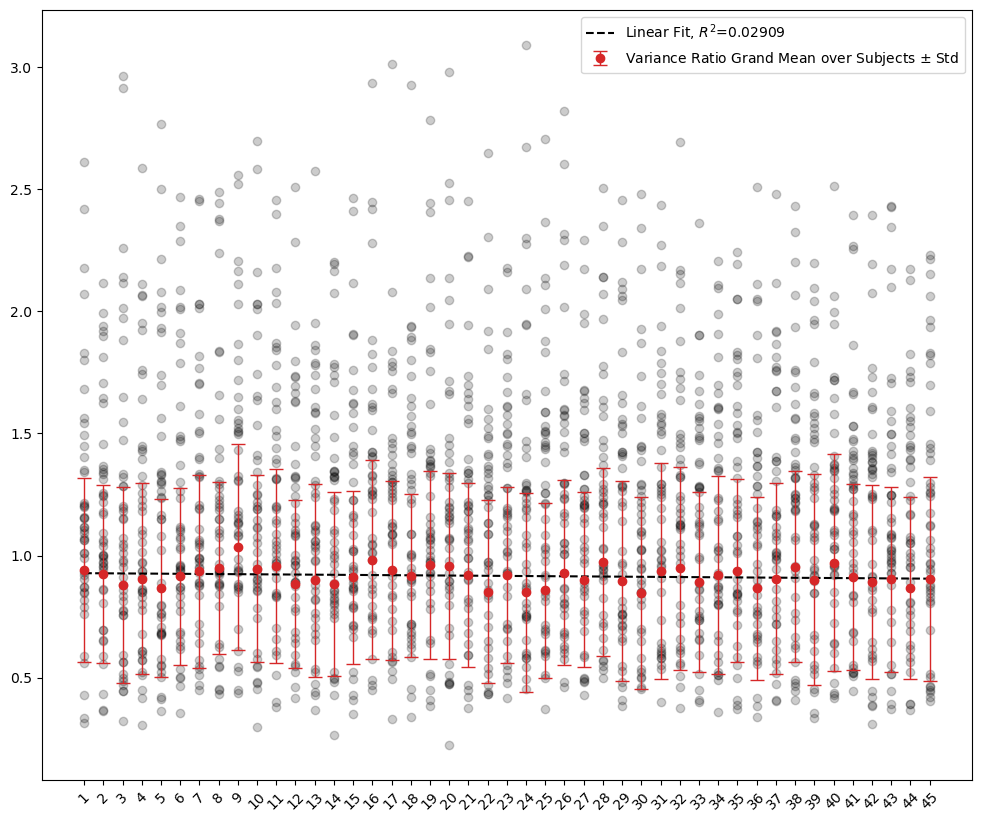

In [19]:
print(emg_block_ratios.shape)
# num_non_nan = np.count_nonzero(~np.isnan(emg_block_ratios))

plt.figure(figsize=(12,10))
# mean of each block's ratios, subjects x block
mean_over_blocks = np.nanmean(emg_block_ratios,axis=(2))
for subject_block_ratio in mean_over_blocks:
    plt.plot(subject_block_ratio, "ko", alpha=0.2)
x = range(45)
plt.errorbar(x, np.nanmedian(emg_block_ratios,axis=(0,2)), yerr=scipy.stats.iqr(emg_block_ratios,axis=(0,2),nan_policy="omit",rng=(40,60)), marker="o", capsize=5, elinewidth=1, linewidth=0, color="tab:red",label="Variance Ratio Grand Mean over Subjects $\pm$ Std")
result = scipy.stats.linregress(range(45), np.nanmedian(emg_block_ratios,axis=(0,2)))
plt.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
plt.xticks(range(45),labels=range(1,46),rotation=45)
plt.legend()

~~## stddev of emg variance ratio within each block VS block (mean over subjects~~

(46, 45, 12)
(46, 45)


/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


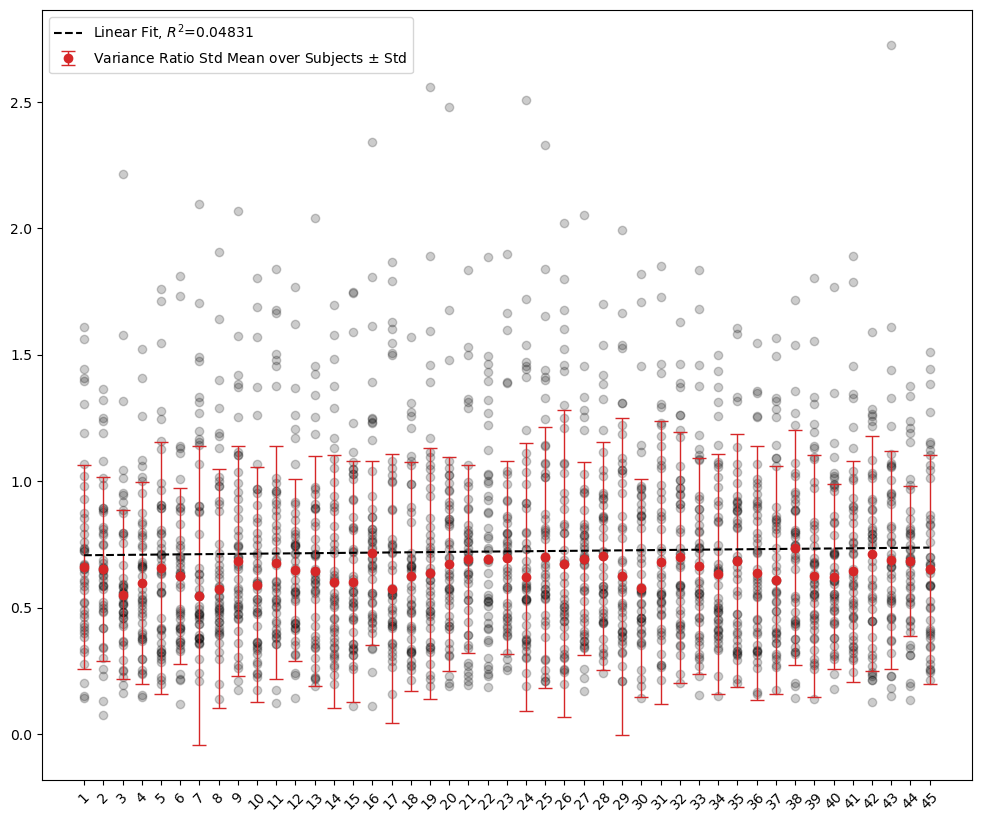

In [20]:
print(emg_block_ratios.shape)
# num_non_nan = np.count_nonzero(~np.isnan(emg_block_ratios))

plt.figure(figsize=(12,10))
std_over_blocks = np.nanstd(emg_block_ratios,axis=(2))
print(std_over_blocks.shape)
for subject_block_ratio in std_over_blocks:
    plt.plot(subject_block_ratio, "ko", alpha=0.2)
x = range(45)
# mean over subjects
plt.errorbar(x, np.nanmedian(std_over_blocks,axis=(0)), yerr=scipy.stats.iqr(std_over_blocks,axis=(0)), marker="o", capsize=5, elinewidth=1, linewidth=0, color="tab:red",label="Variance Ratio Std Mean over Subjects $\pm$ Std")
result = scipy.stats.linregress(x, np.nanmean(std_over_blocks,axis=(0)))
plt.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
plt.xticks(range(45),labels=range(1,46),rotation=45)
plt.legend()

## zoom in on target 5 -- over trials, each subject's ratio for that target, mean over subjects

(46, 12) (46, 45, 12)


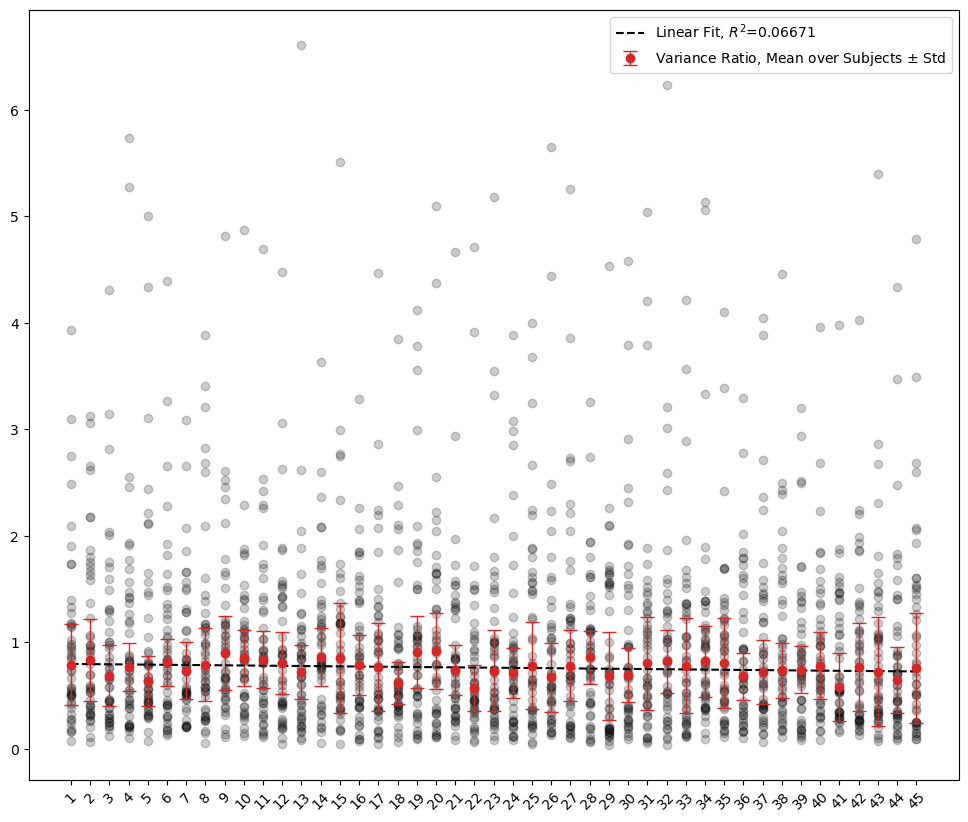

In [21]:
print(hit_end_ratio_stack.shape, emg_ratios.shape)

target_5_hit_end = hit_end_ratio_stack[:,4]
emg_ratios_target_5 = emg_ratios[:,:,4]

plt.figure(figsize=(12,10))
# plt.plot(target_5_hit_end, label="Hit End Ratio")
for trial_ratio in emg_ratios_target_5:
    plt.plot(trial_ratio, "ko",alpha=0.2)
plt.errorbar(range(45), np.nanmedian(emg_ratios_target_5,axis=(0)),yerr=scipy.stats.iqr(emg_ratios_target_5,axis=(0),nan_policy="omit",rng=(40,60)), marker="o", capsize=5, elinewidth=1, linewidth=0, color="tab:red",label="Variance Ratio, Mean over Subjects $\pm$ Std")
result = scipy.stats.linregress(x, np.nanmedian(emg_ratios_target_5,axis=(0)))
plt.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
plt.xticks(range(45),labels=range(1,46),rotation=45)
plt.legend()